In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import copy

import torch
import torch.nn.functional as F

import sys

sys.path.append("/content/drive/MyDrive/neuro_research/stp_networks/stable_paper/")
# sys.path.append('/content/drive/MyDrive/neuro_research/stp_networks/')
import networks as nets
import net_utils as net_utils
import int_data as syn
import analysis as analysis
import context_data as context
from data import generate_recog_data, generate_recog_data_batch
from plotting import plot_generalization, get_recog_positive_rates

c_vals = [
    "firebrick",
    "darkgreen",
    "blue",
    "darkorange",
    "m",
    "deeppink",
    "r",
    "gray",
    "g",
    "navy",
    "y",
    "purple",
    "cyan",
    "olive",
    "skyblue",
    "pink",
    "tan",
]
c_vals_l = [
    "salmon",
    "limegreen",
    "cornflowerblue",
    "bisque",
    "plum",
    "pink",
    "tomato",
    "lightgray",
    "g",
    "b",
    "y",
    "purple",
    "cyan",
    "olive",
    "skyblue",
    "pink",
    "tan",
]


def participation_ratio_vector(C):
    """Computes the participation ratio of a vector of variances."""
    return np.sum(C) ** 2 / np.sum(C * C)

### Reload

In [2]:
# Reload modules if changes have been made to them
from importlib import reload

reload(net_utils)
reload(nets)
reload(syn)
reload(analysis)
reload(context)

<module 'context_data' from '/content/drive/MyDrive/neuro_research/stp_networks/stable_paper/context_data.py'>

Some utility functions for initializing, saving, and loading various networks

In [12]:
from net_utils import xe_classifier_accuracy

import copy
import os
import pickle


def default_params(net_params):
    # Applies default parameters. Note this was implemented only when writing
    # rebuttal, so if certain parameters are not in saved nets they are default

    if "modulation_bounds" not in net_params:
        net_params["modulation_bounds"] = False
    if "mod_bound_val" not in net_params:
        net_params["mod_bound_val"] = 1.0

    return net_params


def init_net(net_params, verbose=True):
    # Set defaults
    net_params = default_params(net_params)

    # initialize net with default values
    if net_params["netType"] == "nnLSTM":
        net = nets.nnLSTM(
            [net_params["n_inputs"], net_params["n_hidden"], net_params["n_outputs"]]
        )
    elif net_params["netType"] == "GRU":
        net = nets.GRU(
            [net_params["n_inputs"], net_params["n_hidden"], net_params["n_outputs"]],
            trainableState0=net_params["trainable_state0"],
            hiddenBias=net_params["hidden_bias"],
            roBias=net_params["ro_bias"],
            fAct=net_params["f_act"],
            fOutAct=net_params["f0_act"],
            freezeInputs=net_params["freeze_inputs"],
            sparsification=net_params["sparsification"],
            noiseType=net_params["noise_type"],
            noiseScale=net_params["noise_scale"],
            verbose=verbose,
        )
    elif net_params["netType"] == "VanillaRNN":
        net = nets.VanillaRNN(
            [net_params["n_inputs"], net_params["n_hidden"], net_params["n_outputs"]],
            trainableState0=net_params["trainable_state0"],
            hiddenBias=net_params["hidden_bias"],
            roBias=net_params["ro_bias"],
            fAct=net_params["f_act"],
            fOutAct=net_params["f0_act"],
            freezeInputs=net_params["freeze_inputs"],
            sparsification=net_params["sparsification"],
            noiseType=net_params["noise_type"],
            noiseScale=net_params["noise_scale"],
            verbose=verbose,
        )
    elif net_params["netType"] in (
        "HebbNet",
        "HebbNet_M",
        "rHebbNet",
        "rHebbNet_M",
        "GHU",
        "GHU_M",
    ):
        if net_params["netType"] in ("HebbNet_M", "rHebbNet_M", "GHU_M"):
            stpType = "mult"
        else:
            stpType = "add"
        if net_params["netType"] in ("HebbNet", "HebbNet_M"):
            netClass = nets.HebbNet
        elif net_params["netType"] in ("rHebbNet", "rHebbNet_M"):
            netClass = nets.RecHebbNet
        elif net_params["netType"] in ("GHU", "GHU_M"):
            netClass = nets.GHU

        net = netClass(
            [net_params["n_inputs"], net_params["n_hidden"], net_params["n_outputs"]],
            trainableState0=net_params["trainable_state0"],
            stpType=stpType,
            hiddenBias=net_params["hidden_bias"],
            roBias=net_params["ro_bias"],
            updateType="hebb",
            lamClamp=net_params["lam_clamp"],
            hebbType=net_params["hebb_type"],
            etaType=net_params["eta_type"],
            freezeInputs=net_params["freeze_inputs"],
            sparsification=net_params["sparsification"],
            noiseType=net_params["noise_type"],
            noiseScale=net_params["noise_scale"],
            AAct=net_params["A_act"],
            modulation_bounds=net_params["modulation_bounds"],
            mod_bound_val=net_params["mod_bound_val"],
            fAct=net_params["f_act"],
            fOutAct=net_params["f0_act"],
            verbose=verbose,
        )

        if net_params["eta_force"] == "Hebb":
            net.forceHebb = torch.tensor(True)
            net.init_hebb(
                eta=net.eta.item(), lam=net.lam.item()
            )  # need to re-init for this to work
        elif net_params["eta_force"] == "Anti":
            net.forceAnti = torch.tensor(True)
            net.init_hebb(eta=net.eta.item(), lam=net.lam.item())
        elif net_params["eta_force"] is not None:
            raise ValueError
    else:
        raise ValueError

    return net


def save_net(
    net, net_params, dataset_details, root_path, overwrite=False, verbose=True
):
    """
    Saves the network as well as the dicts net_params and toy_params which
    will allow the network be reinitialized. Unfortunately couldn't figure
    out how to do this without saving to two different files.

    INPUTS:
    dataset_details: either toy_params or a dictionary of neuroGym parameters

    """

    save_file = True

    if "data_type" in dataset_details:  # toy_params case
        filename = (
            root_path
            + "{}[{},{},{}]_train={}_task={}_{}class_{}len_seed{}.pkl".format(
                net_params["netType"],
                net_params["n_inputs"],
                net_params["n_hidden"],
                net_params["n_outputs"],
                net_params["train_mode"],
                dataset_details["data_type"],
                dataset_details["n_classes"],
                dataset_details["phrase_length"],
                net_params["seed"],
            )
        )
    elif "dataset" in dataset_details:  # neruoGym case
        dataset_details = copy.deepcopy(dataset_details)
        del dataset_details[
            "dataset"
        ]  # Sometimes cant pickle this, so just remove the dataset
        filename = root_path + "{}[{},{},{}]_train={}_task={}_{}len_seed{}.pkl".format(
            net_params["netType"],
            net_params["n_inputs"],
            net_params["n_hidden"],
            net_params["n_outputs"],
            net_params["train_mode"],
            dataset_details["dataset_name"],
            dataset_details["seq_length"],
            net_params["seed"],
        )
    else:
        raise ValueError("dataset_details not recognized")

    directory = os.path.split(filename)[0]
    if directory != "" and not os.path.exists(directory):
        os.makedirs(directory)

    if os.path.exists(filename):
        print("  File already exists at:", filename)
        override = input("Override? (Y/N):")
        if override == "N":
            save_file = False
        elif override != "Y":
            raise ValueError(f"Input {override} not recognized!")

    # if not overwrite:
    #     base, ext = os.path.splitext(filename)
    #     n = 2
    #     while os.path.exists(filename):
    #         filename = '{}_({}){}'.format(base, n, ext)
    #         n+=1

    state_filename = filename[: filename.find(".pkl")] + "_netstate.pkl"

    if save_file:
        if verbose:
            print("  Params filename:", filename)
        with open(filename, "wb") as save_file:
            # Saves additional parameters so the network can be re-initialized
            pickle.dump(net_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(dataset_details, save_file, protocol=pickle.HIGHEST_PROTOCOL)

        # Calls a reset state to set batch size to default (=1)
        # (doesn't affect anything, just prevents a warning when loading)
        if net_params["netType"] in (
            "HebbNet",
            "HebbNet_M",
        ):
            net.reset_state()

        if verbose:
            print("  State filename:", state_filename)
        with open(state_filename, "wb") as save_file:
            # Uses Pytorch's internal saving protocal for the network last
            net.save(save_file)
    else:
        print("  File not saved!")


def load_net(filename, seed):
    """
    Loads the net_params and toy_params, and uses this to re-init a network.

    filename: should be the filename of the pkl file where the net_params
        and toy_params are located WITHOUT SEED OR .pkl
    """
    filename = filename + "_seed{}.pkl".format(seed)

    if not os.path.exists(filename):
        raise ValueError("No file at path:", filename)
    else:
        state_filename = filename[: filename.find(".pkl")] + "_netstate.pkl"

        with open(filename, "rb") as load_file:
            net_params_load = pickle.load(load_file)
            dataset_details_load = pickle.load(
                load_file
            )  # toy_params or dataset_details

        # Using loaded net and toy parameters, creates new network
        net_load = init_net(net_params_load, verbose=False)

        with open(state_filename, "rb") as load_file:
            net_load.load(load_file)

        return net_load, net_params_load, dataset_details_load

### **NeuroGym stuff**

In [4]:
# Install gym
! pip install gym
# Install neurogym
! git clone https://github.com/gyyang/neurogym.git
%cd neurogym/
! pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'neurogym'...
remote: Enumerating objects: 10956, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 10956 (delta 69), reused 90 (delta 34), pack-reused 10827
Receiving objects: 100% (10956/10956), 8.16 MiB | 18.08 MiB/s, done.
Resolving deltas: 100% (8255/8255), done.
/content/neurogym
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/neurogym
  Preparing metadata (setup.py) ... done
  Running setup.py develop for neurogym


In [14]:
import neurogym as ngym

# Environment
tasks = ("GoNogo-v0",)

# All supervised tasks:
tasks = (
    "ContextDecisionMaking-v0",
    # 'DelayComparison-v0',
    # 'DelayMatchCategory-v0',
    # 'DelayMatchSample-v0',
    # 'DelayMatchSampleDistractor1D-v0',
    # 'DelayPairedAssociation-v0',
    # 'DualDelayMatchSample-v0',
    # 'GoNogo-v0',
    # 'HierarchicalReasoning-v0',
    # 'IntervalDiscrimination-v0',
    # 'MotorTiming-v0',
    # 'MultiSensoryIntegration-v0',
    # 'OneTwoThreeGo-v0',
    # 'PerceptualDecisionMaking-v0',
    # 'PerceptualDecisionMakingDelayResponse-v0',
    # 'ProbabilisticReasoning-v0',
    # 'PulseDecisionMaking-v0',
    # # 'ReachingDelayResponse-v0', # Different input type, so omitted
    # 'ReadySetGo-v0',
    # 'SingleContextDecisionMaking-v0',
)

kwargs = {"dt": 100}
seq_len = 100

datasets_params = []

for task_idx, task in enumerate(tasks):
    # Make supervised dataset
    dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16, seq_len=seq_len)

    dataset_params = {
        "dataset_name": task,
        "seq_length": seq_len,
        "dt": kwargs["dt"],
        "dataset": dataset,
        "convert_inputs": True,  # Remap inputs through a random matrix + bias
        "input_dim": 10,
    }

    env = dataset.env
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    print("Task {}: {}".format(task_idx, task))
    print("  Observation size: {}, Action size: {}".format(ob_size, act_size))

    datasets_params.append(dataset_params)

Task 0: ContextDecisionMaking-v0
  Observation size: 7, Action size: 3


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
from net_utils import random_weight_init


def convert_ngym_dataset(dataset_params, set_size=None, device="cpu"):
    """
    This converts a neroGym dataset into one that the MPN code base can use.

    Mostly just transposes the batch and sequence dimensions, then combines
    them into a TensorDataset. Also creates a mask of all trues since
    sequence respose is expected at all time steps.
    """

    dataset = dataset_params["dataset"]

    if set_size is not None:
        dataset.batchsize = set_size  # Just create as a single large batch for now

    inputs, labels = dataset()

    # Default in our setup (batch, seq_idx, :) so need to swap dims
    inputs = np.transpose(inputs, axes=(1, 0, 2))
    labels = np.transpose(
        labels,
        axes=(
            1,
            0,
        ),
    )[:, :, np.newaxis]

    if dataset_params["convert_inputs"]:
        # If the conversion is not already generated, create it
        if "convert_mat" not in dataset_params:
            W, b = random_weight_init(
                [inputs.shape[-1], dataset_params["input_dim"]], bias=True
            )
            dataset_params["convert_mat"] = W[0]
            dataset_params["convert_b"] = b[0][np.newaxis, np.newaxis, :]

        inputs = (
            np.matmul(inputs, dataset_params["convert_mat"].T)
            + dataset_params["convert_b"]
        )

    # Mask is always just all time steps, so creates all True array
    masks = np.ones((inputs.shape[0], inputs.shape[1], act_size))

    inputs = (
        torch.from_numpy(inputs).type(torch.float).to(device)
    )  # inputs.shape (16, 100, 3)
    labels = (
        torch.from_numpy(labels).type(torch.long).to(device)
    )  # labels.shape = (16, 100, 1)
    masks = torch.tensor(masks, dtype=torch.bool, device=device)

    trainData = torch.utils.data.TensorDataset(inputs, labels)

    return trainData, masks, dataset_params

Train a single neruoGym task

In [8]:
train = False
save = False
save_root = "/content/drive/MyDrive/neuro_research/stp_networks/saved_nets/"
# save_root = '/content/drive/MyDrive/neuro_research/stp_networks/saved_nets/anti_task_'

net_params = {
    "netType": "HebbNet_M",  # HebbNet, HebbNet_M, VanillaRNN, GRU, rHebbNet, rHebbNet_M, GHU, GHU_M
    "n_inputs": ob_size,  # input dim
    "n_hidden": 100,  # hidden dim
    "n_outputs": act_size,  # output dim
    "f_act": "tanh",  # 1st layer actiivation function # linear, sigmoid, tanh, relu
    "f0_act": "linear",  # 2nd layer actiivation function
    "trainable_state0": False,
    # STPN Features
    "A_act": None,  # Activation on the A update (tanh or None)
    "lam_clamp": 0.95,  # Maximum lambda value
    "eta_type": "scalar",  # scalar or vector
    "eta_force": None,  # ensure either Hebbian or anti-Hebbian plasticity
    "hebb_type": "inputOutput",  # input, output, inputOutput
    "modulation_bounds": False,  # bound modulations
    "mod_bound_val": 0.1,
    # Train parameters
    "train_mode": "seq_inf",  # 'seq' or 'seq_inf'
    "weight_reg": "L1",
    "reg_lambda": 1e-4,
    "hidden_bias": True,
    "ro_bias": False,  # use readout bias or not
    "gradient_clip": 10,
    "freeze_inputs": False,  # freeze the input layer (and hidden bias)
    "sparsification": 0.0,  # Amount to sparsify network's weights (0.0 = no sparsification)
    "noise_type": "input",  # None, 'input', 'hidden'
    "noise_scale": 0.1,  # Expected magnitude of noise vector
    "cuda": True,
    "validEarlyStop": True,  # Early stop when average validation loss saturates
    "accEarlyStop": None,  # Accuracy to stop early at (None to ignore)
    "minMaxIter": (100, 200),  # (2000, 10000),  # Bounds on training time
    "seed": 1003,  # This seed is used to generate training/valid data too
    "train_set_size": 3200,
    "valid_set_size": 250,
    "batch_size": 32,
    "epochs": 40,
}

if dataset_params["convert_inputs"]:
    net_params["n_inputs"] = dataset_params["input_dim"]


def train_network_ngym(
    net_params,
    dataset_params,
    current_net=None,
    save=False,
    save_root="",
    set_seed=True,
    verbose=True,
):
    """
    Code to train a single network using a neuroGym dataset

    OUTPUTS:
    net: the trained network

    """

    # Sets the random seed for reproducibility (this affects both data generation and network)
    if "seed" in net_params and set_seed:
        if net_params["seed"] is not None:
            np.random.seed(seed=net_params["seed"])
            torch.manual_seed(net_params["seed"])

    # Intitializes network and puts it on device
    if net_params["cuda"]:
        if verbose:
            print("Using CUDA...")
        device = torch.device("cuda")
    else:
        if verbose:
            print("Using CPU...")
        device = torch.device("cpu")
    if current_net is None:  # Creates a new network
        net = init_net(net_params, verbose=verbose)
        # print('w1:', net.w1.detach().numpy()[:2,:2])
        # print('b1:', net.b1.detach().numpy()[:2])
        # print('wr:', net.wr.detach().numpy()[:2,:2])
        # print('wri:', net.wri.detach().numpy()[:2,:2])
        net.to(device)
    else:
        net = current_net

    # Creats the data and trains the network, this is done different for different training setups
    if (
        net_params["train_mode"] == "seq_inf"
    ):  # Continually generates new data to train on
        # This will iterate in loop so that it only sees each type of data a set amount of times
        net_params["epochs"] = 0 if current_net is None else net.hist["epoch"]

        validData, validOutputMask, dataset_params = convert_ngym_dataset(
            dataset_params, set_size=net_params["valid_set_size"], device=device
        )

        early_stop = False
        new_thresh = True  # Triggers threshold setting for first call of .fit, but turns off after first call

        while not early_stop:
            net_params["epochs"] += 10  # Number of times it sees each example
            trainData, trainOutputMask, dataset_params = convert_ngym_dataset(
                dataset_params, set_size=net_params["train_set_size"], device=device
            )

            early_stop = net.fit(
                "sequence",
                epochs=net_params["epochs"],
                trainData=trainData,
                batchSize=net_params["batch_size"],
                validBatch=validData[:, :, :],
                learningRate=1e-3,
                newThresh=new_thresh,
                monitorFreq=50,
                trainOutputMask=trainOutputMask,
                validOutputMask=validOutputMask,
                validStopThres=net_params["accEarlyStop"],
                weightReg=net_params["weight_reg"],
                regLambda=net_params["reg_lambda"],
                gradientClip=net_params["gradient_clip"],
                earlyStopValid=net_params["validEarlyStop"],
                minMaxIter=net_params["minMaxIter"],
            )
            new_thresh = False
    else:
        raise ValueError

    if save:
        save_net(
            net, net_params, dataset_params, save_root, overwrite=False, verbose=verbose
        )
    else:
        print("Not saving network.")

    return net, net_params


if train:
    dataset_params = datasets_params[0]
    net, net_params = train_network_ngym(
        net_params, dataset_params, save=save, save_root=save_root
    )
else:
    print("Not training (set train=True if you want to train).")

Not training (set train=True if you want to train).


#### Train many NeroGym tasks at once



In [16]:
n_trials = 1
acc_thresh = 0.99
valid_early_stop = True
min_max_iter = (2000, 10000)  # Minimum and maximum number of iterations

save = True
save_root_start = (
    "/content/drive/MyDrive/neuro_research/stp_networks/saved_nets/ngym_test_saving"
)

for task_idx, task in enumerate(tasks):
    save_root = save_root_start

    dataset_params = datasets_params[task_idx]

    print("Task {}: {}".format(task_idx, dataset_params["dataset_name"]))

    env = dataset_params["dataset"].env
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    for trial_idx in range(n_trials):
        # Note redefines toy_params internal to the loop so that a new random
        # set of word vectors will be drawn for each trial
        ########## Toy data parameters ##########
        net_params = {
            "netType": "HebbNet_M",  # HebbNet, HebbNet_M, VanillaRNN, GRU, rHebbNet, rHebbNet_M, GHU, GHU_M
            "n_inputs": ob_size,  # input dim
            "n_hidden": 100,  # hidden dim
            "n_outputs": act_size,  # output dim
            "f_act": "tanh",  # 1st layer actiivation function # linear, sigmoid, tanh, relu
            "f0_act": "linear",  # 2nd layer actiivation function
            "trainable_state0": False,
            # STPN Features
            "A_act": None,  # Activation on the A update (tanh or None)
            "lam_clamp": 0.99,  # Maximum lambda value
            "eta_type": "scalar",  # scalar or vector
            "eta_force": None,  # ensure either Hebbian or anti-Hebbian plasticity
            "hebb_type": "inputOutput",  # input, output, inputOutput
            # Train parameters
            "train_mode": "seq_inf",  # 'seq' or 'seq_inf'
            "weight_reg": "L1",
            "reg_lambda": 1e-4,
            "hidden_bias": True,
            "ro_bias": True,  # use readout bias or not
            "gradient_clip": 10,
            "freeze_inputs": False,  # freeze the input layer (and hidden bias)
            "sparsification": 0.0,  # Amount to sparsify network's weights (0.0 = no sparsification)
            "noise_type": None,  # None, 'input', 'hidden'
            "noise_scale": 0.0,  # Expected magnitude of noise vector
            "cuda": True,
            "validEarlyStop": valid_early_stop,  # Early stop when average validation loss saturates
            "accEarlyStop": acc_thresh,  # Accuracy to stop early at (None to ignore)
            "minMaxIter": min_max_iter,  # Bounds on training time
            "seed": 1011
            + trial_idx,  # This seed is used to generate training/valid data too
            "train_set_size": 3200,
            "valid_set_size": 250,
            "batch_size": 32,
            "epochs": 40,
        }

        if dataset_params["convert_inputs"]:
            net_params["n_inputs"] = dataset_params["input_dim"]

        # Hidden bias is on for all networks now
        # # Keep forgetting to turn this on for RNNs, so just automate it
        # net_params['hidden_bias'] = False if net_params['netType'] in ('HebbNet', 'HebbNet_M') else True

        print("Trial: {}".format(trial_idx))
        verbose = True if trial_idx == 0 else False

        net, net_params = train_network_ngym(
            net_params, dataset_params, save=save, save_root=save_root, verbose=verbose
        )

Task 0: ContextDecisionMaking-v0
Trial: 0
Using CUDA...
Net parameters:
  Net Type: Multiplicative
  Structure: f: tanh // fOut: linear // (Nx, Nh, Ny) = (10, 100, 3)
  Hidden bias: trainable // Readout bias: trainable // Sparsification: 0.00 // Noise type: None
  A parameters:
    A update: Hebbian // A Act: linear // Eta: scalar // Lam: scalar // Lambda_max: 0.99
    A0: zeros // A unbounded
Train parameters:
  Loss: XE // LR: 1.00e-03 // Weight reg: L1, coef: 1.0e-04 // Gradient clip: 1.0e+01
Iter:0 grad:5.524 train_loss:0.3948 train_acc:0.950 valid_loss:0.4356 valid_acc:0.948
Iter:50 grad:5.622 train_loss:0.1333 train_acc:0.956 valid_loss:0.1465 valid_acc:0.952
Iter:100 grad:6.040 train_loss:0.0703 train_acc:0.977 valid_loss:0.0722 valid_acc:0.973
Iter:150 grad:6.305 train_loss:0.0552 train_acc:0.979 valid_loss:0.0588 valid_acc:0.974
Iter:200 grad:6.298 train_loss:0.0513 train_acc:0.982 valid_loss:0.0539 valid_acc:0.977
  Early Stop: maximum iterations reached, acc: 0.96
  Params f

Load and evaluate

In [ ]:
load_root_start = "/content/drive/MyDrive/neuro_research/stp_networks/saved_nets/ngym_"

# n_trials = 5 # For main text figure
n_trials = 10  # For eta > 0 and eta < 0 figure

load_types = [
    "convert10_2factor2_HebbNet_M[10,100,{}]_train=seq_inf_task={}_{}len",  # note extra 2 here, original did not have acc cap
    "convert10_1factorsmall_HebbNet_M[10,100,{}]_train=seq_inf_task={}_{}len",
    # 'convert10_1factor_GRU[10,100,{}]_train=seq_inf_task={}_{}len',
    # 'convert10_1factor_VanillaRNN[10,100,{}]_train=seq_inf_task={}_{}len',
]

init_seed = 1000
test_set_size = 250

accs = np.zeros(
    (
        len(load_types),
        len(tasks),
        n_trials,
    )
)
accs_pos_eta = [[[] for _ in range(len(tasks))] for _ in range(len(load_types))]
accs_neg_eta = [[[] for _ in range(len(tasks))] for _ in range(len(load_types))]

for task_idx, task in enumerate(tasks):
    # Uses the dataset_params array created above just to specify loading name
    dataset_params = datasets_params[task_idx]
    print("Task {}: {}".format(task_idx, dataset_params["dataset_name"]))

    # Have to recreate the dataset in dataset_params_load since its not saved
    kwargs = {"dt": dataset_params["dt"]}
    dataset = ngym.Dataset(
        dataset_params["dataset_name"],
        env_kwargs=kwargs,
        batch_size=16,
        seq_len=dataset_params["seq_length"],
    )

    env = dataset.env
    ob_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    for load_idx, load_type in enumerate(load_types):
        for trial_idx in range(n_trials):
            load_path = load_root_start + load_type.format(
                act_size, dataset_params["dataset_name"], dataset_params["seq_length"]
            )

            net_load, net_params_load, dataset_params_load = load_net(
                load_path, init_seed + trial_idx
            )
            # Have to recreate the dataset in dataset_params_load since its not saved
            kwargs = {"dt": dataset_params_load["dt"]}
            dataset_params_load["dataset"] = ngym.Dataset(
                dataset_params_load["dataset_name"],
                env_kwargs=kwargs,
                batch_size=16,
                seq_len=dataset_params_load["seq_length"],
            )

            if "convert_inputs" not in dataset_params_load:
                dataset_params_load["convert_inputs"] = False

            testData, testOutputMask, _ = convert_ngym_dataset(
                dataset_params_load,
                set_size=net_params_load["valid_set_size"],
                device=torch.device("cpu"),
            )

            db_load = net_load.evaluate_debug(
                testData[:, :, :], batchMask=testOutputMask
            )
            accs[load_idx, task_idx, trial_idx] = db_load["acc"]

            # Special eta signed accuracies
            if load_idx in (
                0,
                1,
            ):  # MPN or MPNpre
                eta = net_load.eta.detach().cpu().numpy()[0, 0, 0]
                if eta > 0:
                    accs_pos_eta[load_idx][task_idx].append(db_load["acc"])
                else:
                    accs_neg_eta[load_idx][task_idx].append(db_load["acc"])

        print("  Acc: {:.3f}".format(np.mean(accs[load_idx, task_idx, :], axis=-1)))
        if load_idx in (
            0,
            1,
        ):
            print(
                "    Pos eta: {}, Neg eta: {}".format(
                    len(accs_pos_eta[load_idx][task_idx]),
                    len(accs_neg_eta[load_idx][task_idx]),
                )
            )

Task 0: ContextDecisionMaking-v0
  Acc: 0.993
    Pos eta: 7, Neg eta: 3
  Acc: 0.981
    Pos eta: 6, Neg eta: 4
Task 1: DelayComparison-v0
  Acc: 0.996
    Pos eta: 7, Neg eta: 3
  Acc: 0.987
    Pos eta: 7, Neg eta: 3
Task 2: DelayMatchCategory-v0
  Acc: 0.910
    Pos eta: 7, Neg eta: 3
  Acc: 0.916
    Pos eta: 8, Neg eta: 2
Task 3: DelayMatchSample-v0
  Acc: 0.998
    Pos eta: 7, Neg eta: 3
  Acc: 0.933
    Pos eta: 7, Neg eta: 3
Task 4: DelayMatchSampleDistractor1D-v0
  Acc: 0.935
    Pos eta: 5, Neg eta: 5
  Acc: 0.905
    Pos eta: 6, Neg eta: 4
Task 5: DelayPairedAssociation-v0
  Acc: 0.999
    Pos eta: 5, Neg eta: 5
  Acc: 0.964
    Pos eta: 5, Neg eta: 5
Task 6: DualDelayMatchSample-v0
  Acc: 0.988
    Pos eta: 7, Neg eta: 3
  Acc: 0.941
    Pos eta: 6, Neg eta: 4
Task 7: GoNogo-v0
  Acc: 1.000
    Pos eta: 5, Neg eta: 5
  Acc: 1.000
    Pos eta: 5, Neg eta: 5
Task 8: HierarchicalReasoning-v0
  Acc: 0.774
    Pos eta: 8, Neg eta: 2
  Acc: 0.673
    Pos eta: 7, Neg eta: 3
Task 

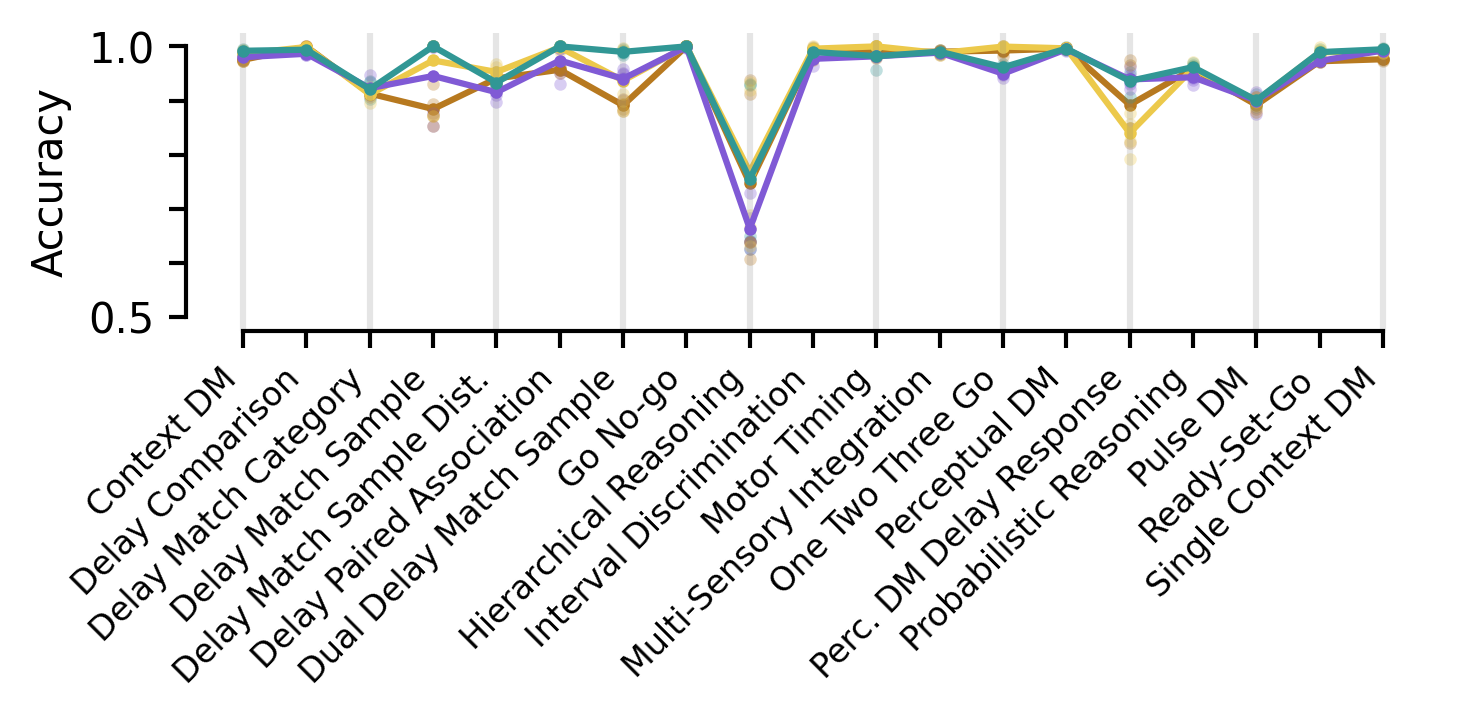

In [ ]:
task_names = (
    "Context DM",
    "Delay Comparison",
    "Delay Match Category",
    "Delay Match Sample",
    "Delay Match Sample Dist.",
    "Delay Paired Association",
    "Dual Delay Match Sample",
    "Go No-go",
    "Hierarchical Reasoning",
    "Interval Discrimination",
    "Motor Timing",
    "Multi-Sensory Integration",
    "One Two Three Go",
    "Perceptual DM",
    "Perc. DM Delay Response",
    "Probabilistic Reasoning",
    "Pulse DM",
    # 'ReachingDelayResponse-v0',
    "Ready-Set-Go",
    "Single Context DM",
)

load_colors = (c_vals[5], c_vals[3], c_vals_dl[8], "#ecc94b")
load_idx_names = ("MPN_2", "MPN_1", "GRU", "VanillaRNN")
load_order = (
    2,
    1,
    -2,
    -1,
)  # Puts MPN first

fig1, ax1 = plt.subplots(1, 1, figsize=(5, 2.5))

for load_idx, load_type in enumerate(load_types):
    ax1.plot(
        np.arange(len(tasks)),
        np.mean(accs[load_idx], axis=-1),
        color=load_colors[load_idx],
        label=load_idx_names[load_idx],
        marker=".",
        zorder=load_order[load_idx],
    )

    for task_idx, task in enumerate(tasks):
        ax1.scatter(
            task_idx * np.ones((n_trials,)),
            accs[load_idx, task_idx],
            color=load_colors[load_idx],
            marker=".",
            zorder=-1,
            alpha=0.3,
            linewidth=0,
        )

ax1.set_xticks(np.arange(len(tasks)))
ax1.set_xticklabels(task_names, rotation=45, fontsize=8, ha="right")

ax1.set_ylim((0.5, 1.0))
ax1.set_yticks((0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
ax1.set_yticklabels((0.5, None, None, None, None, 1.0))
ax1.set_ylabel("Accuracy")
# ax1.legend()

for it in range(0, len(tasks), 2):
    ax1.axvline(it, color="grey", alpha=0.2, zorder=-1)